<a href="https://colab.research.google.com/github/MathiasSchindlerCPH/BSE-T2-CML2-repo/blob/main/msch_kNN_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Extended Project 1: $k$-Nearest Neighbours and Support Vector Machines**

---



Course: Computation Machine Learning II

Submission Date: Feb 20, 2022

Student: Mathias Schindler

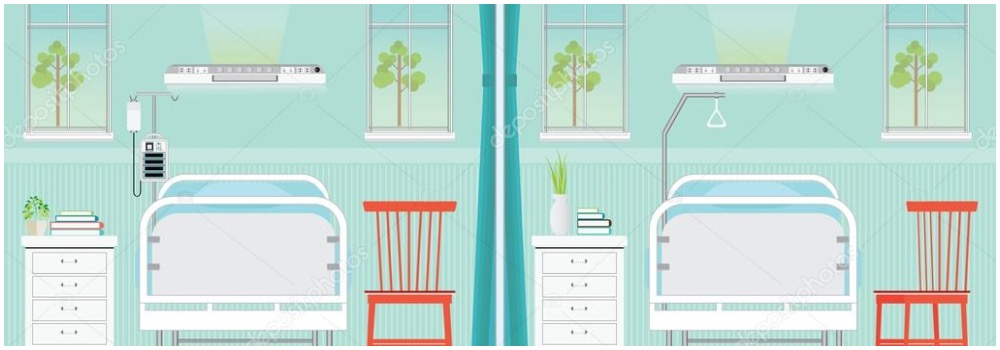

# **0. Preamble**

In [1]:
# Mount G Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Set path
import os
os.chdir('/content/drive/My Drive/--T2-CML2/Project1 - kNN, SVM')

In [3]:
!ls

data  extra_data  mschindler_functions_v3.py  msch_kNN_v1.ipynb  __pycache__


In [4]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime, timedelta

from sklearn import preprocessing

In [5]:
# Import custom functions
import mschindler_functions_v3 as my_fcts
dir(my_fcts)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'construct_age_admit',
 'datetime',
 'make_feat_importance_plot',
 'make_multi_point_pred',
 'make_nan_fig',
 'make_roc_plot',
 'make_scree_plot',
 'np',
 'pd',
 'plot_confusion_matrix',
 'plt',
 'reweight',
 'reweight_proba_multi',
 'sns',
 'timedelta']

# **1. EDA**

Exploratory Data Analysis

## 1.1 Load Data

In [6]:
# Load data
df_train = pd.read_csv("data/mimic_train.csv", index_col=1)
df_test = pd.read_csv("data/mimic_test_death.csv", index_col=1)

In [7]:
# Remove identifier variables
df_train = df_train.drop(['icustay_id'], axis = 1)
df_test = df_test.drop(['subject_id', 'icustay_id'], axis = 1)

## 1.2 Data Types

In [8]:
# Check which variables are neither int or float and drop
print(df_train.dtypes); print('\n')
print(df_test.dtypes)

HOSPITAL_EXPIRE_FLAG      int64
hadm_id                   int64
HeartRate_Min           float64
HeartRate_Max           float64
HeartRate_Mean          float64
SysBP_Min               float64
SysBP_Max               float64
SysBP_Mean              float64
DiasBP_Min              float64
DiasBP_Max              float64
DiasBP_Mean             float64
MeanBP_Min              float64
MeanBP_Max              float64
MeanBP_Mean             float64
RespRate_Min            float64
RespRate_Max            float64
RespRate_Mean           float64
TempC_Min               float64
TempC_Max               float64
TempC_Mean              float64
SpO2_Min                float64
SpO2_Max                float64
SpO2_Mean               float64
Glucose_Min             float64
Glucose_Max             float64
Glucose_Mean            float64
GENDER                   object
DOB                      object
DOD                      object
ADMITTIME                object
DISCHTIME                object
DEATHTIM

Variables `GENDER`, `DOB`, `ADMITTIME`, `ADMISSION_TYPE`, `INSURANCE`, `RELIGION`, `MARITAL_STATUS`, `ETHNICITY`, `DIAGNOSIS`, `ICD9_diagnosis`, `FIRST_CAREUNIT` are string.


## 1.3 Missing Data

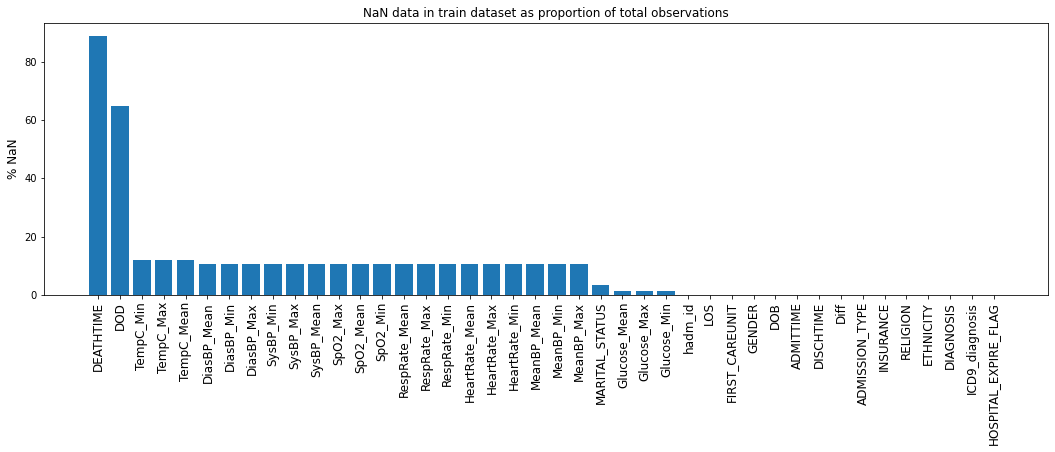

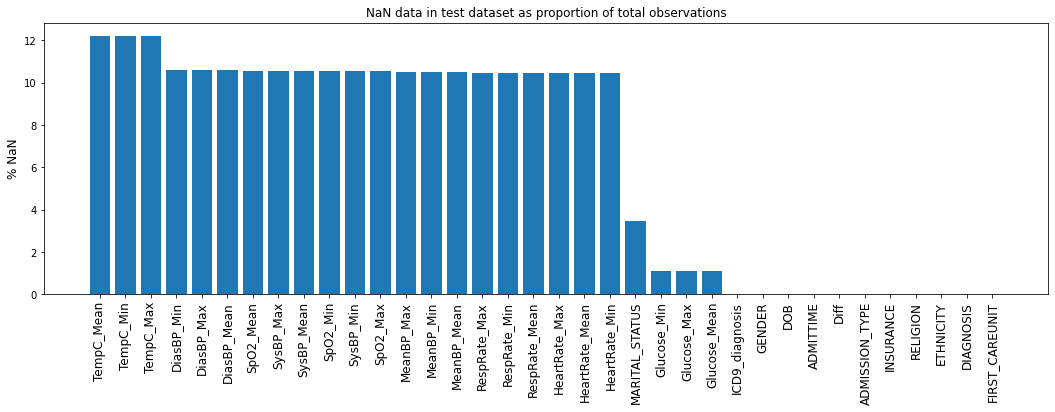

<BarContainer object of 36 artists>

In [9]:
# Investigate missing data
my_fcts.make_nan_fig(df_train, 'train')
my_fcts.make_nan_fig(df_test, 'test')

## 1.4 Feature Distribution

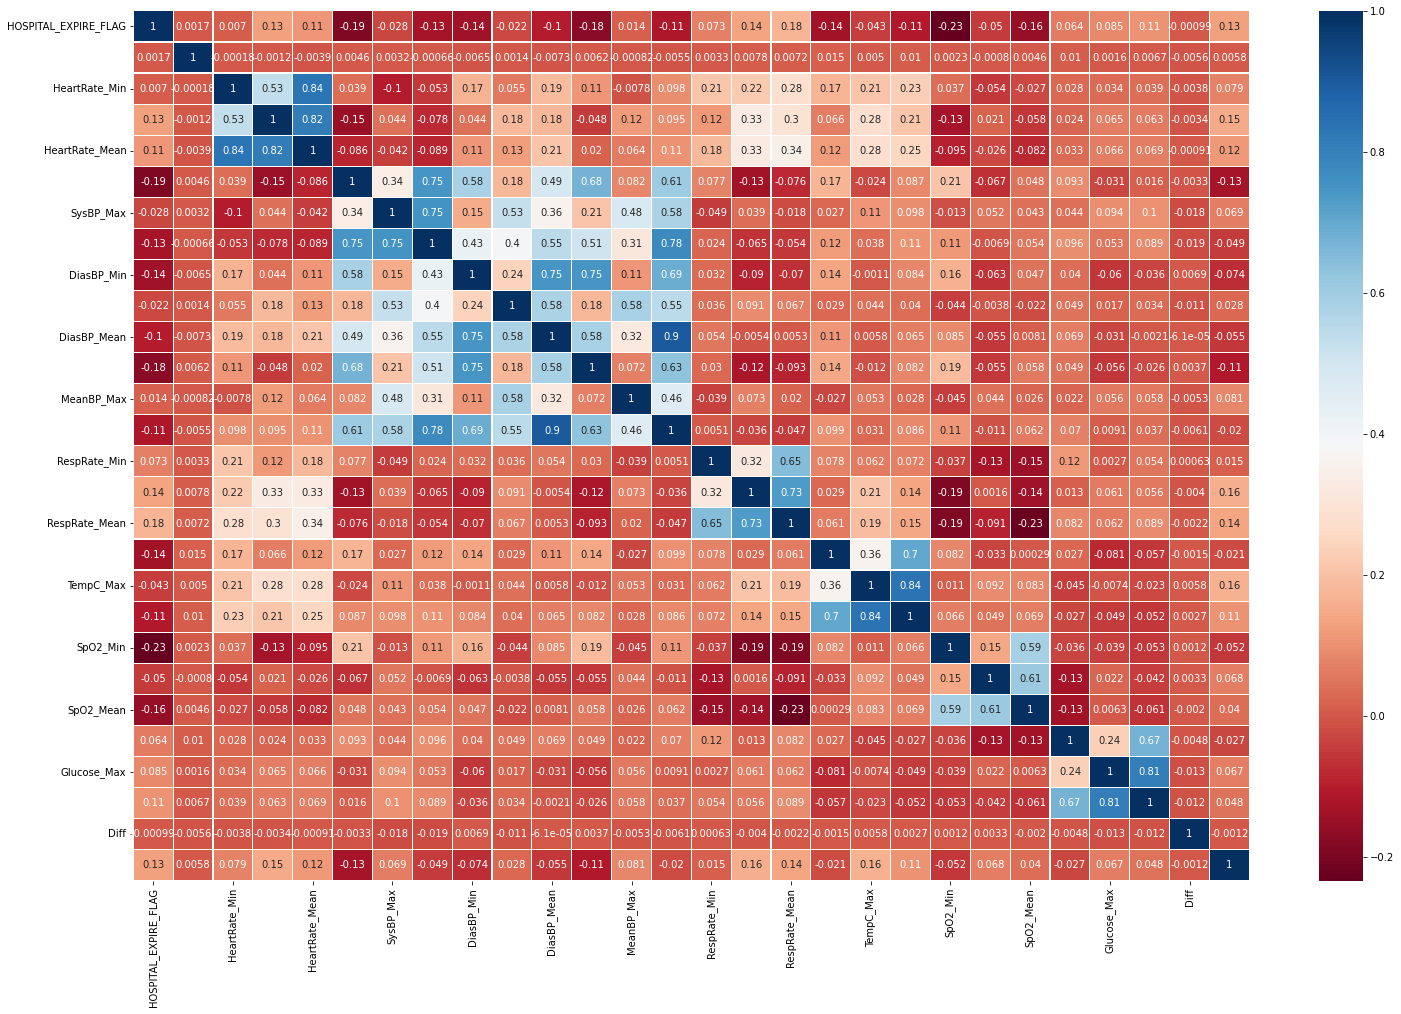

In [10]:
# plot a heatmap
colormap = plt.cm.RdBu

sns.heatmap(df_train.corr(), 
            linewidths=0.1, 
            square=False, 
            cmap=colormap, 
            linecolor='white', 
            annot=True)
fig = plt.gcf()
fig.set_size_inches(25, 16)

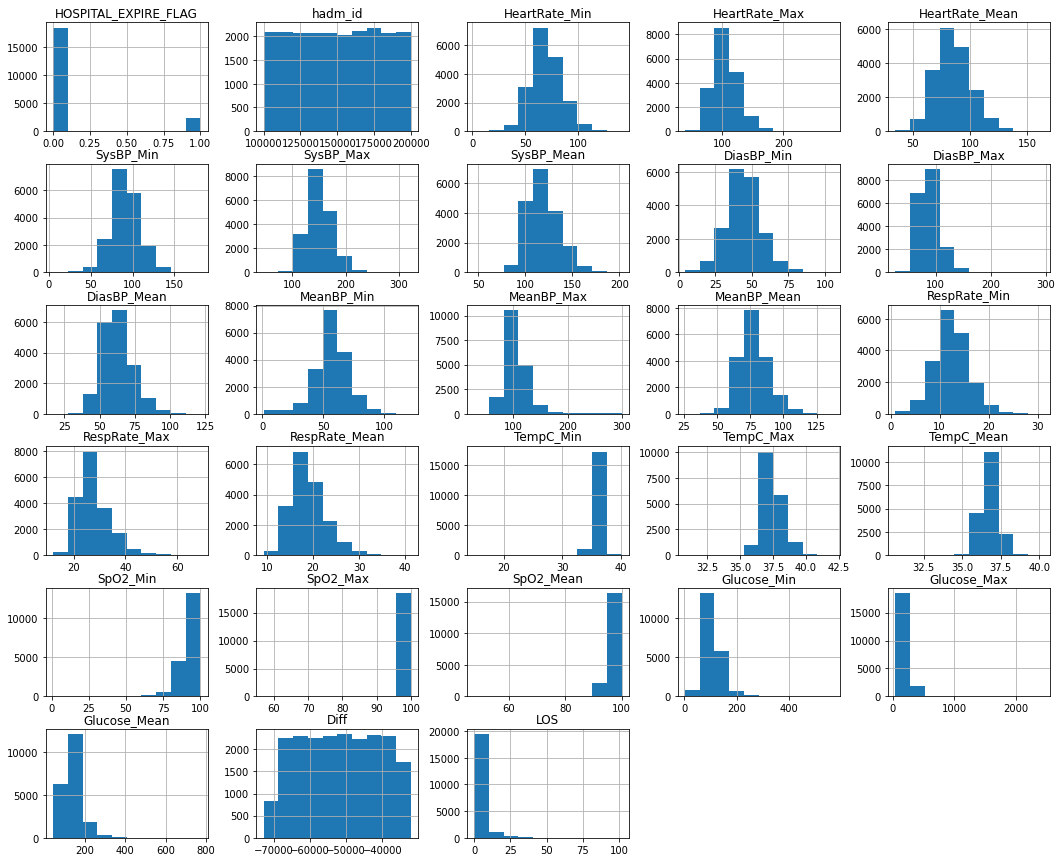

In [11]:
# Plot each covariate distribution
df_train.hist()
fig = plt.gcf()
fig.set_size_inches(18, 15)
plt.show()

# **2. Feature Engineering**

### 2.1 Age-at-Admission Variable

Format admission datetime (see custom functions in external .py-file with custom functions).

In [12]:
df_train_age = my_fcts.construct_age_admit(df_train)
df_test_age = my_fcts.construct_age_admit(df_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


**Inspection of created age variable**

In [13]:
# Check if missing values were generated
print(df_train_age['age_at_admin'].isnull().any() )
print(df_test_age['age_at_admin'].isnull().any() )

False
False


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


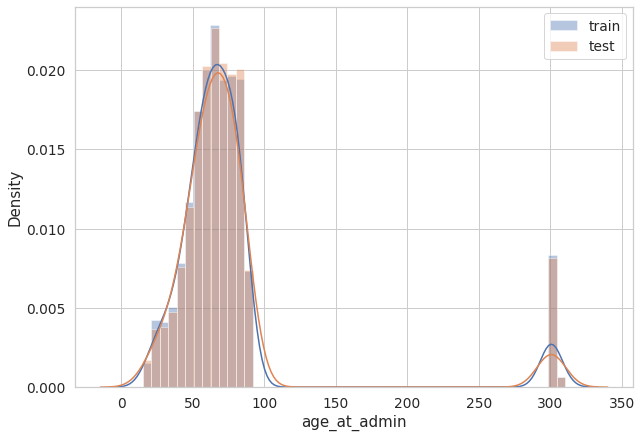

In [14]:
# Global sns settings
sns.set(rc = {'figure.figsize':(10,7)}, font_scale=1.25)
sns.set_style("whitegrid")

# Make density plot
sns.distplot(df_train_age['age_at_admin'], label='train')
sns.distplot(df_test_age['age_at_admin'], label='test')

# Add legend
plt.legend()

In [15]:
#Count of 
print("No. of individuals in train more than 100 years old: " + str(df_train_age[df_train_age['age_at_admin'] > 100]['age_at_admin'].count()))
print("\n Value counts in train for those >100 years:")
print(df_train_age[df_train_age['age_at_admin'] > 100]['age_at_admin'].value_counts() )

print("\n")

print("No. of individuals in test more than 100 years old: " + str(df_test_age[df_test_age['age_at_admin'] > 100]['age_at_admin'].count()))
print("\n Value counts in test for those >100 years:")
print(df_test_age[df_test_age['age_at_admin'] > 100]['age_at_admin'].value_counts() )

No. of individuals in train more than 100 years old: 1107

 Value counts in train for those >100 years:
299.994524    795
300.054757      4
306.877481      3
300.021903      3
300.027379      3
             ... 
305.733060      1
304.290212      1
303.085558      1
302.291581      1
303.498973      1
Name: age_at_admin, Length: 270, dtype: int64


No. of individuals in test more than 100 years old: 270

 Value counts in test for those >100 years:
299.994524    201
304.859685      2
300.027379      2
302.297057      1
300.202601      1
             ... 
301.642710      1
303.181383      1
300.711841      1
300.257358      1
303.241615      1
Name: age_at_admin, Length: 68, dtype: int64


So, for those over 100 years old they are 299 to 303 years old. Seems quite unrealistic. In order to not delete observations (and for a lack of better alternative) these values are replaced by the median.



---


**NOTE TO SELF:** Revisit this imputation with fancier methods and making sure that no information from train ''spills over'' to test data. 
<br>
Maybe use clustering to impute age from individuals with similar conditions. Prob older people show different characteristics than younger people -> problematic imputing median for all. Co-morbidity info would prob help here.

---



In [16]:
# Train
median_train = df_train_age.loc[df_train_age['age_at_admin']<100, 'age_at_admin'].median()
df_train_age.loc[df_train_age.age_at_admin >= 100, 'age_at_admin'] = np.nan
df_train_age.fillna(median_train, inplace=True)

# Test
median_test = df_test_age.loc[df_test_age['age_at_admin']<100, 'age_at_admin'].median()
df_test_age.loc[df_test_age.age_at_admin >= 100, 'age_at_admin'] = np.nan
df_test_age.fillna(median_test, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


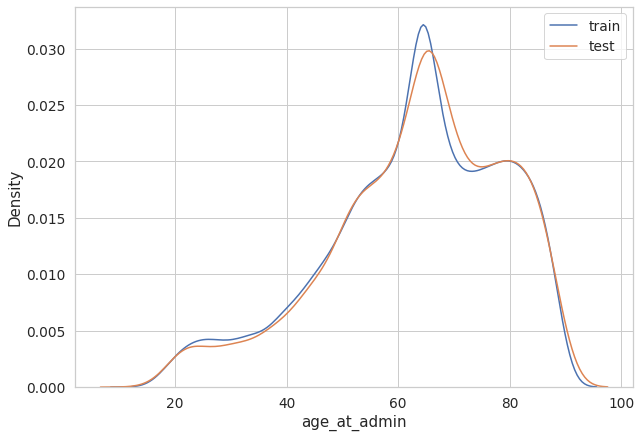

In [17]:
# Global sns settings
sns.set(rc = {'figure.figsize':(10,7)}, font_scale=1.25)
sns.set_style("whitegrid")

# Make density plot
sns.distplot(df_train_age['age_at_admin'], label='train', hist = False)
sns.distplot(df_test_age['age_at_admin'], label='test', hist = False)

# Add legend
plt.legend()

# **3. Preprocessing Data**

Compare features in both data sets

In [18]:
print("Features in train data but not in test:")
print(df_train_age.columns.difference(df_test_age.columns) )

print("\n Features in test data but not in train:")
print(df_test_age.columns.difference(df_train_age.columns) )

Features in train data but not in test:
Index(['DEATHTIME', 'DISCHTIME', 'DOD', 'HOSPITAL_EXPIRE_FLAG', 'LOS',
       'hadm_id'],
      dtype='object')

 Features in test data but not in train:
Index([], dtype='object')


In [19]:
# Remove features in train that are not in test (except target 'HOSPITAL_EXPIRE_FLAG')
df_train_age = df_train_age.drop(['DEATHTIME', 'DISCHTIME', 'DOD', 'LOS', 'hadm_id'], axis = 1)

In [20]:
print(df_train_age.columns.difference(df_test_age.columns) )
print(df_test_age.columns.difference(df_train_age.columns) )

Index(['HOSPITAL_EXPIRE_FLAG'], dtype='object')
Index([], dtype='object')


## 3.0 Split Categorical and Numerical Data

In [27]:
# Numerical Data
cat_feats = ["GENDER", "ADMISSION_TYPE", "INSURANCE", "RELIGION", "MARITAL_STATUS", 
             "ETHNICITY", "DIAGNOSIS", "ICD9_diagnosis", "FIRST_CAREUNIT"]

df_train_num = df_train_age.drop(cat_feats, axis = 1)
df_test_num = df_test_age.drop(cat_feats, axis = 1)

In [28]:
# Categorical Data
df_train_cat = df_train[cat_feats]
df_test_cat = df_test[cat_feats]

In [29]:
# Split target
y_train = df_train_num['HOSPITAL_EXPIRE_FLAG']
df_train_num = df_train_num.drop(['HOSPITAL_EXPIRE_FLAG'], axis = 1)

Temporary: Compare again

In [30]:
# Compare numerical features
print(df_train_num.columns.difference(df_test_num.columns) )
print(df_test_num.columns.difference(df_train_num.columns) )

Index([], dtype='object')
Index([], dtype='object')


In [31]:
# Compare categorical features
print(df_train_cat.columns.difference(df_test_cat.columns) )
print(df_test_cat.columns.difference(df_train_cat.columns) )

Index([], dtype='object')
Index([], dtype='object')


## 3.1 Numerical Features 

### 3.1.1 Standardization

Data will be standardized with mean zero and unit variance. This such that distance measures are in comparable units.

In [32]:
# Instantiate scaler
scaler = preprocessing.StandardScaler()

# Fit to data
scaler.fit(df_train_num)

# Transform data
df_train_scl = scaler.transform(df_train_num)
df_test_scl = scaler.transform(df_test_num)

# Format data
df_train_scl = pd.DataFrame(df_train_scl, columns = df_train_num.columns, index = df_train_num.index)
df_test_scl = pd.DataFrame(df_test_scl, columns = df_test_num.columns, index = df_test_num.index)

## 3.2 Categorical Features

### 3.2.1 One-Hot Encoding

Inspecting for which features it would be feasible to construct dummy variables.<br>
Features `GENDER`, `ADMISSION_TYPE`, `INSURANCE`, `MARITAL_STATUS` and `FIRST_CAREUNIT` are chosen for one-hot encoding. These seem relevant for the later task of predicting mortality, while having a not-too-large number of categories (so dimensionality does not explode).



---


**NOTE TO SELF:** Also try one-hotting everything and then dimensionality-reducing with PCA and/or SVD

---



In [35]:
for c in cat_feat:
  print(c)
  print(df_train_cat[c].value_counts() )
  print("\n\n")

GENDER
M    11759
F     9126
Name: GENDER, dtype: int64



ADMISSION_TYPE
EMERGENCY    17817
ELECTIVE      2848
URGENT         220
Name: ADMISSION_TYPE, dtype: int64



INSURANCE
Medicare      11718
Private        6245
Medicaid       2117
Government      611
Self Pay        194
Name: INSURANCE, dtype: int64



RELIGION
CATHOLIC                  7655
NOT SPECIFIED             5398
PROTESTANT QUAKER         2753
JEWISH                    1840
UNOBTAINABLE              1515
OTHER                      702
EPISCOPALIAN               288
GREEK ORTHODOX             178
CHRISTIAN SCIENTIST        164
BUDDHIST                   109
MUSLIM                      74
UNITARIAN-UNIVERSALIST      54
JEHOVAH'S WITNESS           45
ROMANIAN EAST. ORTH         41
HINDU                       38
7TH DAY ADVENTIST           30
HEBREW                       1
Name: RELIGION, dtype: int64



MARITAL_STATUS
MARRIED              9664
SINGLE               5910
WIDOWED              2819
DIVORCED             1413
S

In [36]:
# One-Hot Encoding
one_hot_feats = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'MARITAL_STATUS', 'FIRST_CAREUNIT']
prfx_dict = {'GENDER': 'gender', 'ADMISSION_TYPE': 'admin_type', 'INSURANCE': 'ins', 'MARITAL_STATUS': 'mar_stat','FIRST_CAREUNIT': 'firstcare'}

df_train_dumm = pd.get_dummies(df_train_cat, prefix=prfx_dict, columns=one_hot_feats, drop_first = True)
df_test_dumm = pd.get_dummies(df_test_cat, prefix=prfx_dict, columns=one_hot_feats, drop_first = True)

In [37]:
# Drop non-one-hot encoded features
drop_cat_feats = [ "RELIGION", "ETHNICITY", "DIAGNOSIS", "ICD9_diagnosis"]

df_train_dumm = df_train_dumm.drop(drop_cat_feats, axis = 1)
df_test_dumm = df_test_dumm.drop(drop_cat_feats, axis = 1)

## 3.3 Concatenate Numerical and Categorical Features

In [38]:
X_train = pd.concat([df_train_scl, df_train_dumm], axis = 1)
X_test = pd.concat([df_test_scl, df_test_dumm], axis = 1)

In [41]:
print("Shape: " + str(X_train.shape))
X_train

Shape: (20885, 42)


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,mar_stat_LIFE PARTNER,mar_stat_MARRIED,mar_stat_SEPARATED,mar_stat_SINGLE,mar_stat_UNKNOWN (DEFAULT),mar_stat_WIDOWED,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55440,1.401323,1.881171,2.403821,-0.772768,-0.419576,-0.293722,-0.346787,0.211967,-0.147957,0.134219,-0.295164,-0.149996,-0.147505,-0.127800,-0.097499,-0.469221,-0.422199,-0.442338,0.166880,0.290344,0.224698,0.134133,0.530088,0.502760,0.420258,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
76908,-0.434704,0.385846,-0.245992,0.038265,-0.591945,-0.287378,0.197926,-0.601741,0.193342,0.061779,-0.637852,-0.127215,-0.269139,-0.836058,-0.534371,-0.336953,-0.460078,-0.398811,0.911246,0.382610,0.550216,-0.092692,-0.835566,-0.770026,-1.297563,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
95798,0.836391,-0.126836,0.548589,-0.015804,-0.103565,-0.025034,-0.113339,-0.957738,-0.565300,0.496416,-0.500776,-0.296937,-0.269139,-0.836058,-0.545404,-0.324928,-0.428513,-0.377219,1.097337,0.382610,0.642504,0.729547,1.777458,1.755297,0.332998,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
40708,0.483309,1.154871,1.001591,-0.232079,-0.189750,-0.276990,-1.280581,0.161110,-1.999426,-0.662616,-0.295164,-1.194351,-0.329956,0.265677,0.209791,-0.336953,-0.131795,-0.247667,-0.949669,0.382610,0.160626,0.049073,-0.448452,-0.285388,0.754583,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
28424,-0.332090,-1.560079,-1.172826,-1.288957,-2.216438,-2.120038,1.400427,-1.087264,0.166472,0.529239,-1.307700,-1.046101,2.860079,2.583501,2.827389,2.706167,2.703788,2.708306,-2.210148,-2.897136,-2.843105,-0.262811,-0.469958,-0.549736,1.033301,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28043,-0.293471,-0.383178,-0.285029,-1.529732,0.528456,-0.103469,-0.969316,0.415394,-0.586988,-1.169692,-0.021013,-0.616927,-0.451589,-0.678668,-0.578747,-0.421124,-0.460078,-0.433975,0.818200,0.382610,0.626161,-1.085050,-0.448452,-0.757438,1.541461,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
87605,0.342076,0.471294,0.388472,0.633023,0.241174,0.429532,0.898271,-0.144030,0.489136,1.220811,-0.123820,0.544496,-0.512406,-0.599972,-0.623119,-0.258794,-0.327502,-0.287326,0.632108,0.382610,0.400427,2.203908,2.110806,2.366902,0.188763,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
47492,-0.787786,-0.169560,-0.384046,0.308609,-0.304663,-0.057486,0.664822,-0.144030,0.446197,0.641295,-0.260895,0.201374,-0.208322,-0.363886,-0.387947,-0.367014,-0.384321,-0.339323,0.818200,0.382610,0.564059,-1.567052,3.003321,1.146496,0.003293,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [42]:
print("Shape: " + str(X_test.shape))
X_test

Shape: (5221, 42)


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,mar_stat_LIFE PARTNER,mar_stat_MARRIED,mar_stat_SEPARATED,mar_stat_SINGLE,mar_stat_UNKNOWN (DEFAULT),mar_stat_WIDOWED,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU
hadm_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
146725,-0.787786,-0.468625,0.141265,-0.610561,0.327358,-0.644650,-0.502419,-0.449171,-1.025864,-0.300418,-0.021013,-0.713347,-0.694857,-0.599972,-0.795890,-0.448780,-0.279523,-0.295215,0.632108,0.382610,0.563224,-0.489635,0.530088,-0.072055,1.169323,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
108789,1.542556,1.881171,2.025370,-0.826837,0.040076,-0.526767,-0.346787,0.008540,0.274424,-0.517737,5.941757,0.778626,0.156579,0.659154,0.162980,-0.367014,-0.138108,-0.247667,0.446017,0.382610,0.413705,1.296609,8.982092,5.585917,-0.903354,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
139885,2.601802,1.325765,2.195665,0.254541,-0.132294,0.123924,0.353558,-0.500027,0.382273,0.206658,-0.535045,0.098904,-0.086688,-0.363886,-0.116699,-0.246769,-0.169674,-0.186925,0.352971,0.382610,0.239382,-0.177751,-0.340920,-0.329446,-1.290719,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
173017,0.200844,0.172229,0.039017,-0.880906,0.758282,0.590305,-0.580236,0.669678,0.013192,-0.807495,0.253137,0.201374,-0.451589,-0.442581,-0.677389,-0.379038,-0.327502,-0.348188,0.073834,0.382610,0.178964,0.672841,-0.039831,0.204757,1.341105,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
171573,1.118857,0.983976,0.985339,-0.123942,0.068804,-0.116885,0.431374,2.398806,0.970019,0.641295,1.109857,0.904437,-0.634040,-0.206495,0.028475,-0.361001,-0.384321,-0.379863,-0.205303,0.382610,0.250278,-0.914931,0.723646,0.386496,-0.615054,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107962,-0.434704,1.283041,0.892459,1.065573,-0.046109,0.401741,0.197926,-0.347457,-0.008187,0.641295,-0.466508,-0.057213,-0.086688,0.108286,0.065595,-0.421124,-0.460078,-0.424104,-0.205303,0.290344,0.058250,1.523434,1.530134,2.115772,-0.237613,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
112243,-0.278246,-1.527503,-1.124635,-1.247730,-2.194533,-2.086988,1.459761,-1.048486,0.239585,0.584474,-1.281570,-0.978385,2.906451,2.643506,2.880356,2.788684,2.790435,2.792977,-2.139202,-2.826784,-2.768338,-0.801519,-0.254894,-0.394064,0.833116,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
156430,0.342076,-0.425901,-0.096157,1.552193,0.844467,1.301759,0.120109,0.567964,0.143094,0.641295,0.424481,0.677426,-0.573223,-0.442581,-0.604692,-0.306891,-0.396947,-0.349738,-0.019212,0.290344,0.038201,0.162486,0.422556,0.585981,1.153411,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
